# Personalized User-level DP

In [1]:
import numpy as np

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')

from personalized_utils import (
    init_heart_disease_param, init_mnist_param,
    make_q_c_curve, plot_q_c_curve, 
    make_epsilon_u, group_by_closest_below,
    static_optimization, show_static_optimization_result,
    prepare_grid_search,
    run_online_optimization, show_online_optimization_result,
    run_with_specified_idx, show_specified_idx_result,
    plot_acc_results,
)
from mylogger import logger_set_warning, logger_set_info


# qC curve

Given following parameters, the q C pair satisfying the privacy constraint has many candidates
- epsilon_u
- delta
- n_round
- sigma


In [ ]:
# Figure of q_c_pair.png
epsilon_u = 3.0
n_total_round = 20
delta = 1e-5
sigma = 0.5
x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_total_round=n_total_round, min=-6)
plot_q_c_curve(
    x, y,
    title=r"$\epsilon_u={}$, $\delta={}$, $\sigma={}$,  $T={}$".format(
                epsilon_u, delta, sigma, n_total_round,
            )
)

In [ ]:
# Figure of q_c_pair.png
epsilon_u = 3.0
n_total_round = 20
delta = 1e-5
sigma = 0.5
x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_total_round=n_total_round, min=-6)
plot_q_c_curve(
    x, y,
    title=r"$\epsilon_u={}$, $\delta={}$, $\sigma={}$,  $T={}$".format(
                epsilon_u, delta, sigma, n_total_round,
            ), is_qC=True,
)

# PULDP-AVG

## Offline HPO

### HeartDisease

#### Parameters

#### Test with all of HPs for showing group-independency (Figure in Appendix)

Basic setting 

(This setup is close to the real world, and each group has a different number of users and different privacy budgets, so the optimal HP is likely to be different.)

- (eps1, eps2, eps3) = (0.15, 3.0, 5.0)
- with ratio (eps1, eps2, eps3) = (0.6, 0.25, 0.15)

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(eps_u=0.5, parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.n_total_round = 30
fed_sim_params.times = 10
static_q_u_list = [1.0, 0.75, 0.5, 0.25, 0.12, 0.06, 0.03]

idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=7)
static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list, force_update=False)
min_idx, min_loss = show_static_optimization_result(
    fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list,
    img_name=f"heart_disease-all", is_3d=True
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

#### Various n_users with a single eps group (Fig in Sec4)

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(eps_u=0.5, parallelized=True)

for n_users in [50, 100, 200, 400]:
    fed_sim_params.n_users = n_users
    idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=12)
    static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=None, force_update=False)
    min_idx, min_loss = show_static_optimization_result(
        fed_sim_params, idx_per_group_list, 
        img_name=f"heart_disease-users-{n_users}"
    )
    print(min_idx, min_loss)

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(
    eps_u=0.5, parallelized=True, dynamic_global_learning_rate=True,
)

for n_users in [50, 100, 200, 400]:
    fed_sim_params.n_users = n_users
    idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=12)
    static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=None, force_update=False)
    min_idx, min_loss = show_static_optimization_result(
        fed_sim_params, idx_per_group_list, 
        img_name=f"heart_disease-users-{n_users}"
    )
    print(min_idx, min_loss)

#### Various eps_u with a single eps group (Fig in Sec4)

In [ ]:
for eps_u in [0.15, 0.5, 1.0, 5.0]:
    fed_sim_params = init_heart_disease_param(eps_u=eps_u, parallelized=True)
    idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=12)
    static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=None, force_update=False)
    min_idx, min_loss = show_static_optimization_result(
        fed_sim_params, idx_per_group_list, 
        img_name=f"heart_disease-uniform-eps-{eps_u}"
    )
    print(min_idx, min_loss)

#### for ULDP-AVG

In [ ]:
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.01]
fed_sim_params = init_heart_disease_param(eps_u=0.15, parallelized=True)
idx_per_group_list = prepare_grid_search(fed_sim_params.get_group_eps_set(), start_idx=0, end_idx=10)
static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list, force_update=False)
min_idx, min_loss = show_static_optimization_result(
    fed_sim_params, idx_per_group_list, 
    static_q_u_list=static_q_u_list,
    img_name=f"{fed_sim_params.dataset_name}-uldpavg",
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

### MNIST

In [ ]:
# static_optimization_dcc96be578cebd23679e769b9b12cc7b.pkl
logger_set_info()
static_q_u_list = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05]
fed_sim_params = init_mnist_param(
    n_users=500, eps_u=3.0, times=2,
    gpu_id=0, parallelized="strong")
idx_per_group_list = prepare_grid_search(
    fed_sim_params.get_group_eps_set(), 
    start_idx=0, end_idx=7
)
static_optimization(fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list, force_update=False)
min_idx, min_loss = show_static_optimization_result(
    fed_sim_params, idx_per_group_list, static_q_u_list=static_q_u_list,
    img_name=f"mnist-all"
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

## Online HPO

### HeartDisease

#### QCTest

##### different initial q_u

Skip: File already exists.
[{'global': {'privacy_budget': [], 'global_test': [(0, 0.44881889763779526, 0.7727653384208679), (1, 0.48031496062992124, 0.7699007391929626), (2, 0.5590551181102362, 0.6998071074485779), (3, 0.5826771653543307, 0.6845199465751648), (4, 0.6062992125984252, 0.7064498066902161), (5, 0.5433070866141733, 0.69321209192276), (6, 0.5433070866141733, 0.6989490389823914), (7, 0.5196850393700787, 0.725018322467804), (8, 0.48031496062992124, 0.7538293600082397), (9, 0.6141732283464567, 0.6611230969429016), (10, 0.6535433070866141, 0.6358490586280823), (11, 0.6771653543307087, 0.6254585385322571), (12, 0.6456692913385826, 0.6415849328041077), (13, 0.6929133858267716, 0.6129558682441711), (14, 0.7086614173228346, 0.5944681763648987), (15, 0.6692913385826772, 0.6263222098350525), (16, 0.6456692913385826, 0.6401128768920898), (17, 0.5669291338582677, 0.6950205564498901), (18, 0.5433070866141733, 0.729965090751648), (19, 0.5590551181102362, 0.7052463293075562), (20, 0.527559

ValueError: x and y must have same first dimension, but have shapes (0,) and (30,)

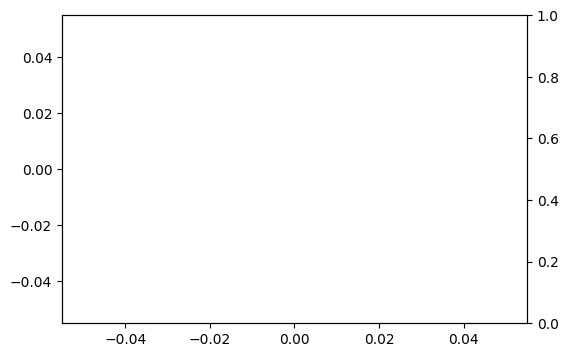

In [2]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=True)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}"
    )
    hd_all_acc_results[(fed_sim_params.agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)


##### different (bigger) step size

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
q_step_size_list = [0.3, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    for q_step_size in q_step_size_list:
        fed_sim_params.initial_q_u = initial_q_u
        fed_sim_params.q_step_size = q_step_size
        run_online_optimization(fed_sim_params, force_update=False)
        x, acc_means, acc_stds = show_online_optimization_result(
            fed_sim_params, errorbar=False,
            img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-q_step_size{q_step_size}"
        )

##### different momentum_weight

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTest"

initial_q_u_list = [0.1, 0.5, 1.0]
momentum_weight_list = [0.5, 0.9]
for initial_q_u in initial_q_u_list:
    for momentum_weight in momentum_weight_list:
        fed_sim_params.initial_q_u = initial_q_u
        fed_sim_params.momentum_weight = momentum_weight
        run_online_optimization(fed_sim_params, force_update=True)
        x, acc_means, acc_stds = show_online_optimization_result(
            fed_sim_params, errorbar=False,
            img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-momentum{momentum_weight}"
        )

#### QCTrain

##### different initial q_u

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=True)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}"
    )
    hd_all_acc_results[(fed_sim_params.agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

##### ablation study: weight decay

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = False

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=True)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-step_decay_off"
    )

##### ablation study: momentum

In [ ]:
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.with_momentum = False

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=False)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{fed_sim_params.agg_strategy}-{initial_q_u}-momentum_off"
    )

#### Baselines

##### Best HP by static optimization (PULDP-AVG)
$(\epsilon_1, \epsilon_2, \epsilon_3) => (q_u=0.1, q_u=0.7, q_u=1.0)$

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG"
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]
best_idx_per_group = {0.15: 6, 3.0: 3, 5.0: 0}

run_with_specified_idx(
    fed_sim_params, best_idx_per_group, 
    static_q_u_list=static_q_u_list, force_update=False
)
x, acc_means, acc_stds = show_specified_idx_result(
    fed_sim_params, best_idx_per_group, static_q_u_list=static_q_u_list, errorbar=False,
    img_name=f"{fed_sim_params.dataset_name}-PULDPAVG"
)
hd_all_acc_results[(fed_sim_params.agg_strategy, "PULDP-AVG (Offline HPO)")] = (x, acc_means, acc_stds)

##### random-updown

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}

logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = True
fed_sim_params.hp_baseline = "random-updown"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=True)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{initial_q_u}-{fed_sim_params.hp_baseline}"
    )
    hd_all_acc_results[(fed_sim_params.hp_baseline, initial_q_u)] = (x, acc_means, acc_stds)

##### Random

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}

logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15, 3.0, 5.0]
fed_sim_params.group_thresholds = [0.15, 3.0, 5.0]
fed_sim_params.ratio_list = [0.6, 0.25, 0.15]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG-QCTrain"
fed_sim_params.step_decay = True
fed_sim_params.hp_baseline = "random"

initial_q_u_list = [0.1, 0.5, 1.0]
for initial_q_u in initial_q_u_list:
    fed_sim_params.initial_q_u = initial_q_u
    run_online_optimization(fed_sim_params, force_update=True)
    x, acc_means, acc_stds = show_online_optimization_result(
        fed_sim_params, errorbar=False,
        img_name=f"{fed_sim_params.dataset_name}-{initial_q_u}-{fed_sim_params.hp_baseline}"
    )
    hd_all_acc_results[(fed_sim_params.hp_baseline, "Random")] = (x, acc_means, acc_stds)

##### ULDP-AVG

In [ ]:
if "hd_all_acc_results" not in locals():
    hd_all_acc_results = {}
logger_set_warning()
fed_sim_params = init_heart_disease_param(parallelized=True)
fed_sim_params.epsilon_list = [0.15]
fed_sim_params.group_thresholds = [0.15]
fed_sim_params.ratio_list = [1.0]
fed_sim_params.validation_ratio = 0.5
fed_sim_params.times = 10
fed_sim_params.agg_strategy = "PULDP-AVG"
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.01]
best_idx_per_group = {0.15: 6}

run_with_specified_idx(
    fed_sim_params, best_idx_per_group, 
    static_q_u_list=static_q_u_list, force_update=False
)
x, acc_means, acc_stds = show_specified_idx_result(
    fed_sim_params, best_idx_per_group, static_q_u_list=static_q_u_list, errorbar=False,
    img_name=f"{fed_sim_params.dataset_name}-ULDPAVG"
)
hd_all_acc_results[(fed_sim_params.agg_strategy, "ULDP-AVG (Baseline)")] = (x, acc_means, acc_stds)

#### Compare all results

In [ ]:
plot_acc_results(fed_sim_params, hd_all_acc_results, initial_q_u_list=[0.1, 0.5, 1.0], errorbar=False)